In [1]:
import os
import glob
import tempfile
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # uncomment for cpu

from itertools import cycle
from collections import Counter as ct

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2



import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer,OneHotEncoder


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
seed =1337

In [2]:
def data_normalise(file_list):
    std = StandardScaler()
    final = []
    for i in file_list:
        df_from_each_file= pd.read_csv(i)
        df_from_each_file.iloc[:,0:11] = pd.DataFrame(std.fit_transform(df_from_each_file.iloc[:,0:11]))
        final.append(df_from_each_file)
    df= pd.concat(final, ignore_index=True)
    return df

In [3]:

df1   = pd.read_csv('./Train/Train.csv')
df2   = pd.read_csv('./Test/Test.csv')


# Model training

In [4]:

df1 = df1.sample(frac=1, random_state=seed).reset_index(drop=True)
df2 = df2.sample(frac=1, random_state=seed).reset_index(drop=True)



X = df1.loc[:, df1.columns!='Cell']
Y = df1['Cell']


x_test = df2.loc[:, df2.columns!='Cell']
y_test =df2['Cell']





# Use a utility from sklearn to split and shuffle your dataset.
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=seed, shuffle=True)


# Create categorical labels
lbl_clf = LabelEncoder()
train_encoded = lbl_clf.fit_transform(y_train)

val_encoded = lbl_clf.fit_transform(y_val)

test_encoded = lbl_clf.fit_transform(y_test)

lbl_clf_name_mapping = dict(zip(lbl_clf.classes_, lbl_clf.transform(lbl_clf.classes_)))
print(lbl_clf_name_mapping)


{'B-Cell': 0, 'DC': 1, 'Eosinophile': 2, 'Monocyte': 3, 'NK': 4, 'Neutrophile': 5, 'T-Cell': 6, 'Unassigned': 7}


In [5]:
n_features = X.shape[1]
n_classes = len(set(train_encoded))

print(f"Parameter: {n_features}    Labels: {n_classes}")

Parameter: 14    Labels: 8


In [6]:
# Create the network

model = Sequential([
    Dense(26, input_dim=n_features, activation='relu',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(56, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(24, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                390       
                                                                 
 batch_normalization (BatchN  (None, 26)               104       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 50)                1350      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 56)                2856      
                                                                 
 dropout (Dropout)           (None, 56)                0

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(x=x_train, y=train_encoded, epochs=30, batch_size=4096, shuffle=True,
                        validation_data=(x_val, val_encoded))

Epoch 1/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.2081 - accuracy: 0.9560 - val_loss: 0.1030 - val_accuracy: 0.9696
Epoch 2/30
2142/2142 [==============================] - 16s 8ms/step - loss: 0.1033 - accuracy: 0.9694 - val_loss: 0.0921 - val_accuracy: 0.9715
Epoch 3/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.0954 - accuracy: 0.9706 - val_loss: 0.0886 - val_accuracy: 0.9715
Epoch 4/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.0923 - accuracy: 0.9711 - val_loss: 0.0875 - val_accuracy: 0.9718
Epoch 5/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.0905 - accuracy: 0.9714 - val_loss: 0.0863 - val_accuracy: 0.9722
Epoch 6/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.0891 - accuracy: 0.9716 - val_loss: 0.0877 - val_accuracy: 0.9713
Epoch 7/30
2142/2142 [==============================] - 16s 7ms/step - loss: 0.0883 - accuracy: 0.9718 - val_loss: 0.0849 - val_ac

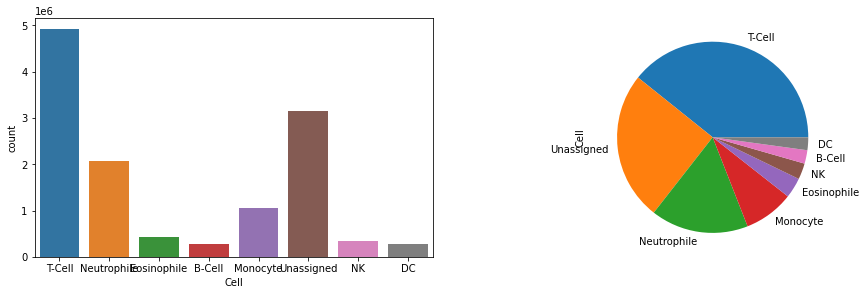

In [9]:
%matplotlib inline
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
fig.tight_layout(pad=5.0)
df1['Cell'].value_counts().plot(kind='pie',ax=axs[1])
sns.countplot(x='Cell',data=df1,ax=axs[0])
plt.show()

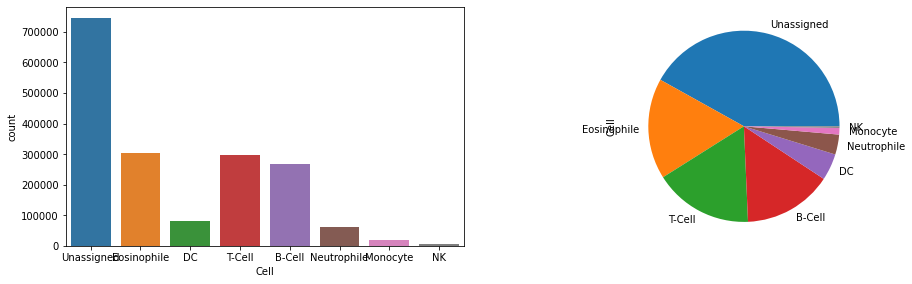

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
fig.tight_layout(pad=5.0)
df2['Cell'].value_counts().plot(kind='pie',ax=axs[1])
sns.countplot(x='Cell',data=df2,ax=axs[0])
plt.show()

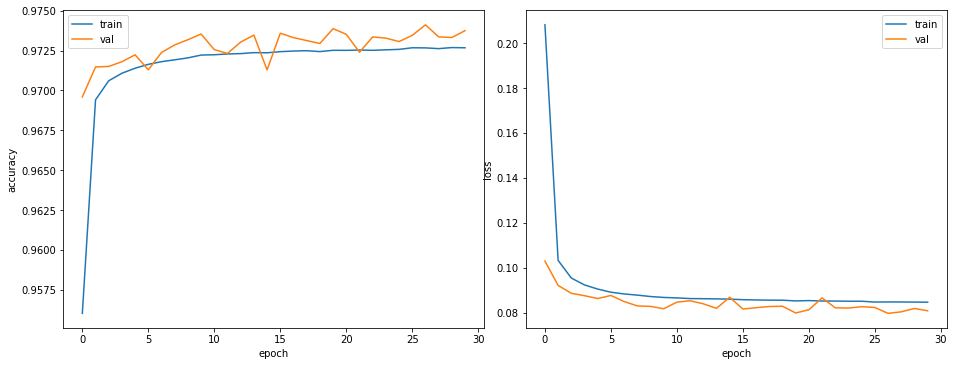

In [11]:
# Accuracy and Loss plots
fig, axs = plt.subplots(ncols=2,figsize=(13, 5))
fig.tight_layout()
sc1=axs[0].plot(history.history['accuracy'])
sc2=axs[0].plot(history.history['val_accuracy'])
axs[0].set(xlabel="epoch", ylabel="accuracy")


sc3=axs[1].plot(history.history['loss'])
sc4=axs[1].plot(history.history['val_loss'])
axs[0].set(xlabel="epoch", ylabel="accuracy")
axs[0].legend(['train', 'val'], loc='upper left')
axs[1].set(xlabel="epoch", ylabel="loss")
axs[1].legend(['train', 'val'], loc='upper right')


plt.show()

# Evalution

In [12]:
predictions = history.model.predict(x_test)

55518/55518 [==============================] - 87s 2ms/step


In [13]:
pred_bool = np.argmax(predictions, axis=1)
target_names=['B-Cell','DC','Eosinophile','Monocyte','NK','Neutrophile','T-Cells','Unassigned']
# Metrics
print(classification_report(test_encoded, pred_bool,target_names=target_names))

              precision    recall  f1-score   support

      B-Cell       0.96      0.33      0.50    267281
          DC       0.78      0.81      0.79     80077
 Eosinophile       0.96      0.96      0.96    302538
    Monocyte       0.87      0.88      0.88     19859
          NK       0.93      0.98      0.95      4804
 Neutrophile       0.95      0.85      0.89     59976
     T-Cells       0.97      0.96      0.96    297282
  Unassigned       0.78      0.97      0.86    744756

    accuracy                           0.86   1776573
   macro avg       0.90      0.84      0.85   1776573
weighted avg       0.88      0.86      0.84   1776573



# Confusion matrix

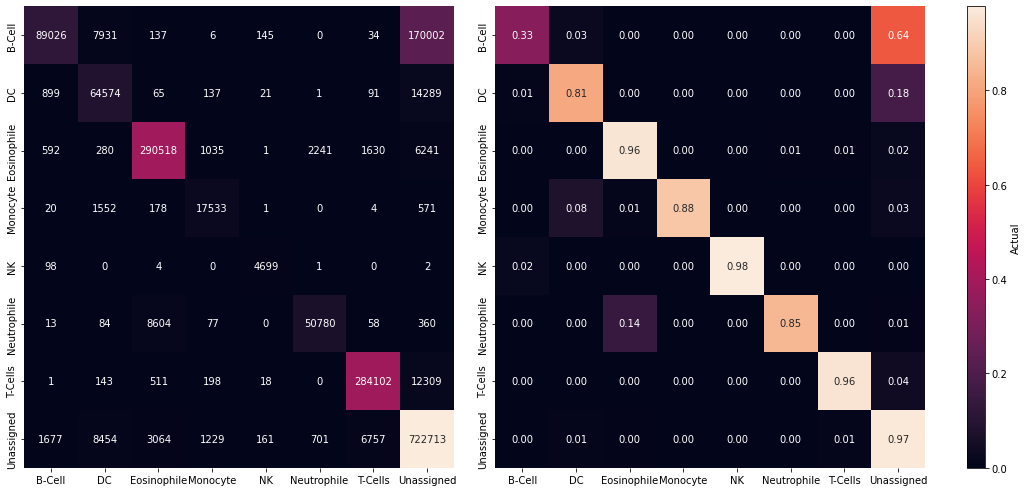

In [14]:
matrix_confusion = confusion_matrix(test_encoded, predictions.argmax(axis=1))

# Normalise
cmn = matrix_confusion.astype('float') / matrix_confusion.sum(axis=1)[:, np.newaxis]
fig, axs = plt.subplots(ncols=3,figsize=(14, 7),gridspec_kw=dict(width_ratios=[12,12,0.5]))
fig.tight_layout()

sns.heatmap(matrix_confusion, annot=True, fmt='.0f',cbar=False, xticklabels=target_names, yticklabels=target_names,ax=axs[0])
sns.heatmap(cmn, annot=True, fmt='.2f',cbar=False, xticklabels=target_names, yticklabels=target_names,ax=axs[1])
fig.colorbar(axs[1].collections[0], cax=axs[2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# ROC curve with auc

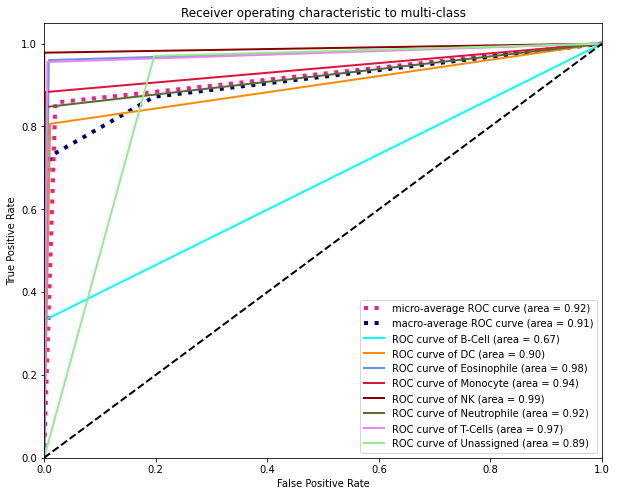

In [15]:
lw = 2

lb = LabelBinarizer()
lb.fit(test_encoded)
y_true = lb.transform(test_encoded)
y_pred = lb.transform(pred_bool)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','crimson','darkred','darkolivegreen','violet','lightgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of {target_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()


In [16]:
test_lst = list(test_encoded)
pred_lst = list(predictions.argmax(axis=1))

full_lst = list(zip(test_lst,pred_lst))


In [20]:
# B cell
indexes = []

for i,x in enumerate(full_lst):
    if x[0]==0:
        if x[1] == 7:
            indexes.append(i)
prob_set =x_test.iloc[indexes]
print(f"H : {sum(prob_set['H'])}")
print(f"M : {sum(prob_set['M'])}")
print(f"R : {sum(prob_set['R'])}")    

print(" Mice Dataset Has High B cell Misclasifications")

H : 408.0
M : 169563.0
R : 31.0
 Mice Dataset Has High B cell Misclasifications


In [18]:
#DC
indexes = []

for i,x in enumerate(full_lst):
    if x[0]==1:
        if x[1] == 6:
            indexes.append(i)
prob_set =x_test.iloc[indexes]
print(f"H : {sum(prob_set['H'])}")
print(f"M : {sum(prob_set['M'])}")
print(f"R : {sum(prob_set['R'])}")    

H : 75.0
M : 0.0
R : 16.0


In [21]:
model.save('./model/')

INFO:tensorflow:Assets written to: ./model/assets
